In [1]:
from evaluation_metric import *

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import xgboost as xgb
import seaborn as sns
import pickle
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

In [2]:
train = pd.read_parquet('Data/train_data_aggV3.parquet')
models = pickle.load(open("Models/xgboost_b1.pkl", "rb"))
train.shape

(458913, 638)

In [3]:
df_scores = []
folds = 10
for i in range(folds):
    mask = train['cid']%folds == i
    va = train[mask]

    xt, yt = va.drop(['customer_ID', 'target', 'cid', 'S_2'], axis=1), va['target']
    dvalid = xgb.DMatrix(data=xt, label=yt)
    
    keys = []
    for j in range(4):
        key = '{}-{}'.format(i,j)
        model = models[key]
        pred = model.predict(dvalid, iteration_range = (0,model.best_iteration))

        pred = pd.DataFrame(pred, columns=['prediction']).reset_index(drop = True)
        yt = pd.DataFrame(yt).reset_index(drop = True)
        
        score = amex_metric(yt, pred)
        df_scores.append((i, j, score))

df_results = pd.DataFrame(df_scores,columns=['fold','seed','score']).pivot(index='fold',columns='seed',values='score')
df_results.loc['seed_mean']= df_results.mean(numeric_only=True, axis=0)
df_results.loc[:,'fold_mean'] = df_results.mean(numeric_only=True, axis=1)

del dvalid
gc.collect()
df_results

seed,0,1,2,3,fold_mean
fold,,,,,
0,0.793920,0.793398,0.793624,0.794076,0.793754
1,0.793522,0.794974,0.794412,0.794801,0.794427
2,0.798908,0.798429,0.800846,0.800047,0.799558
3,0.794846,0.796447,0.793575,0.795646,0.795128
4,0.785267,0.785917,0.786509,0.786154,0.785962
5,0.793922,0.793085,0.791075,0.791652,0.792433
6,0.796355,0.798684,0.795205,0.793637,0.795970
7,0.796857,0.797352,0.795153,0.797738,0.796775
8,0.798118,0.798816,0.797260,0.797605,0.797950


In [4]:
indxmax = df_results.drop('seed_mean', axis=0).idxmax(axis=1).values
list_best_model_keys = []
for i in range(folds):
    list_best_model_keys.append('{}-{}'.format(i, indxmax[i]))
list_best_model_keys

['0-3', '1-1', '2-2', '3-1', '4-2', '5-0', '6-1', '7-3', '8-1', '9-1']

In [40]:
folds = 10
i = 2
mask = train['cid']%folds == i
data = train[mask]
data.set_index('customer_ID', inplace=True)
data_features, data_targets  = data.drop(['target', 'cid', 'S_2'], axis=1), data['target']

data_features_DMatrix = xgb.DMatrix(data=data_features)

key = list_best_model_keys[i]
model = models[key]
pred = model.predict(data_features_DMatrix, iteration_range = (0,model.best_iteration))
pred = pd.DataFrame(pred, columns=['prediction'], index=data_targets.index)

In [70]:
df = pd.concat([pred, data_targets], axis=1)
size = df.shape[0]
pred_train = df.iloc[:int(0.9*size)]
pred_test = df.iloc[int(0.9*size):]
pred_train.shape, pred_test.shape

((41302, 2), (4590, 2))

In [71]:
lr = LogisticRegression()
lr.fit(pred_train['prediction'].to_numpy().reshape(-1, 1), pred_train['target'])

LogisticRegression()

In [72]:
lr.coef_

array([[6.78520236]])

In [73]:
pred_df = pd.DataFrame(pred_test['prediction'], columns=['prediction']).reset_index(drop = True)
yt_df = pd.DataFrame(pred_test['target']).reset_index(drop = True)

In [74]:
amex_metric(yt_df, pred_df)

0.8018804948278312

In [75]:
calibrated_pred = lr.predict_proba(pred_test['prediction'].to_numpy().reshape(-1, 1))[:,1]

In [76]:
calibrated_pred = pd.DataFrame(calibrated_pred, columns=['prediction']).reset_index(drop = True)

In [77]:
amex_metric(yt_df, calibrated_pred)

0.8018804948278312

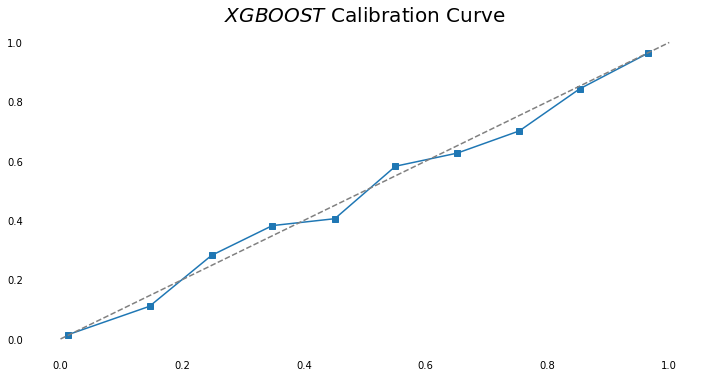

In [78]:
fraction_of_positives, mean_predicted_value = calibration_curve(yt_df, pred_df, n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBOOST$ Calibration Curve", fontsize=20); pass

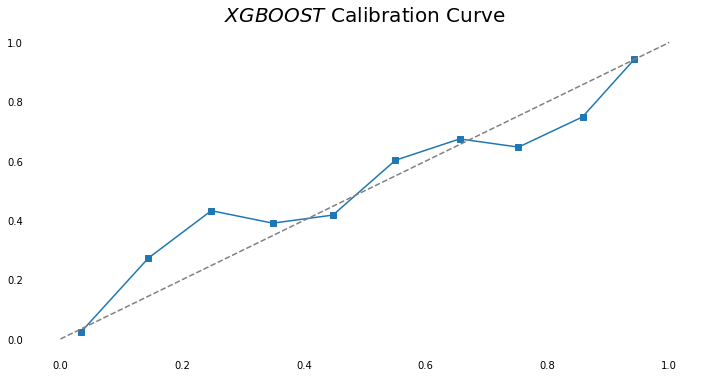

In [79]:
fraction_of_positives, mean_predicted_value = calibration_curve(yt_df, calibrated_pred, n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBOOST$ Calibration Curve", fontsize=20); pass